In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from wufam.data.prepare_data import read_kf_data
from wufam.config.trading_config import TradingConfig
from wufam.dataset import Dataset
from wufam.strategies.base_strategy import BaseStrategy
from wufam.backtest.rolling_features_backtest import run_rolling_features_backtest
from wufam.metrics.metrics import calc_sharpe

PATH = Path("../data/kf_data")
START = "1970-01-01"
END = "2024-12-31"
DATASET = Dataset.BM_25_M
FACTORS_DATASET = Dataset.FACTORS_M
WEIGHTING = "value_weighted"
FACTOR_ANNUALIZE = 252

## 1.8

In [3]:
portfolios_total_r_m, portfolios_xs_r_m, factors_df, rf = read_kf_data(
    portfolios_filename=PATH / DATASET,
    factors_filename=PATH / FACTORS_DATASET,
    start_date=START,
    end_date=END,
    weighting=WEIGHTING,
)

In [4]:
portfolios_total_r, portfolios_xs_r, factors_df, rf = read_kf_data(
    portfolios_filename=PATH / Dataset.BM_25_D,
    factors_filename=PATH / Dataset.FACTORS_D,
    start_date=START,
    end_date=END,
    weighting=WEIGHTING,
)

In [5]:
assert (
    portfolios_total_r.shape[0]
    == portfolios_xs_r.shape[0]
    == factors_df.shape[0]
    == rf.shape[0]
)

In [6]:
mkt_caps = pd.read_csv(
    PATH / DATASET,
    skiprows=3_795,
    skipfooter=8881 - 4_984,
    index_col=0,
    engine="python",
)
mkt_caps.index = pd.to_datetime(mkt_caps.index, format="%Y%m")
mkt_caps = mkt_caps.loc[START:END]
mkt_caps.shape

(660, 25)

In [7]:
bms = pd.read_csv(
    PATH / DATASET,
    skiprows=4_991,
    skipfooter=8881 - 6_181,
    index_col=0,
    engine="python",
)
bms.index = pd.to_datetime(bms.index, format="%Y%m")
bms = bms.loc[START:END]
bms.shape

(660, 25)

In [8]:
ops = pd.read_csv(
    PATH / DATASET,
    skiprows=7_382,
    skipfooter=8881 - 8_128,
    index_col=0,
    engine="python",
)
ops.index = pd.to_datetime(ops.index, format="%Y%m")
ops = ops.loc[START:END]
ops.shape

(660, 25)

In [9]:
invs = pd.read_csv(
    PATH / DATASET,
    skiprows=8_133,
    skipfooter=8881 - 8_878,
    index_col=0,
    engine="python",
)
invs.index = pd.to_datetime(invs.index, format="%Y%m")
invs = invs.loc[START:END]
invs.shape

(660, 25)

In [10]:
lagged_ret = portfolios_xs_r_m.shift(1).fillna(0)
lagged_ret.shape

(660, 25)

In [11]:
stds = portfolios_xs_r_m.rolling(window=21, min_periods=1).std().fillna(0)
stds.shape

(660, 25)

In [12]:
skews = portfolios_xs_r_m.rolling(window=21, min_periods=1).skew().fillna(0)
skews.shape

(660, 25)

In [13]:
dfs_dict = {
    "Market_Caps": mkt_caps.resample("ME").last(),
    "Book_to_Market": bms.resample("ME").last(),
    "Operating_Profitability": ops.resample("ME").last(),
    "Investment": invs.resample("ME").last(),
    "Volatility": stds.resample("ME").last(),
    "Skewness": skews.resample("ME").last(),
    "Momentum": lagged_ret.resample("ME").last(),
    "ret": portfolios_xs_r_m.resample("ME").last().shift(-1).fillna(0),
}

# Stack each DataFrame to convert columns to index level, then concatenate
stacked_dfs = []
for name, df in dfs_dict.items():
    stacked = df.iloc[2:].stack()
    stacked.name = name
    stacked_dfs.append(stacked)

# Concatenate all stacked series along axis=1 (columns)
multi_df = pd.concat(stacked_dfs, axis=1)

# Set proper index names
multi_df.index.names = ["date", "portfolio"]
multi_df.shape

(16450, 8)

In [14]:
rank = (
    multi_df[multi_df.columns.difference(["ret"])]
    .groupby(level="date")
    .rank(ascending=False, method="max")
) + 1
rank = rank.div(rank.groupby(level="date").count()) - 0.5
rank = rank.fillna(0)

In [15]:
tgt = multi_df["ret"]

In [16]:
from wufam.strategies.optimized.unconditional_mean_var import UnconditionalMeanVariance
from wufam.estimation.covariance.shrinkage.lw_cv_cov_estimator import (
    LedoitWolfCVCovEstimator,
)

umve = UnconditionalMeanVariance(
    cov_estimator=LedoitWolfCVCovEstimator(),
    trading_config=TradingConfig(total_exposure=1),
)

In [17]:
def evaluate_strategy(
    strategy: BaseStrategy, return_weights: bool = False
) -> tuple[float, float] | tuple[float, float, pd.DataFrame]:
    bt_results = run_rolling_features_backtest(
        strategy=strategy,
        excess_returns=portfolios_xs_r,
        factors=factors_df,
        cross_sectional_features=rank,
        targets=tgt,
        rf=rf,
        freq="M",
        trading_lag=1,
        return_weights=return_weights,
    )

    if return_weights:
        total_r, turnover, me_weights = bt_results
    else:
        total_r, turnover = bt_results

    sr = calc_sharpe(
        strategy_total_r=total_r,
        rf_rate=rf,
        factor_annualize=FACTOR_ANNUALIZE,
    )

    avg_turnover = turnover.iloc[1:].mean()

    if return_weights:
        return sr, avg_turnover, me_weights

    return sr, avg_turnover

In [18]:
evaluate_strategy(umve)

Optimizing Strategy: 100%|██████████| 655/655 [06:13<00:00,  1.76it/s]


(1.0366954175283543, np.float64(3.5830629721276956))

In [21]:
umve.ridge.coef_

array([-1.91754931e-03,  2.73562923e-03,  1.12205820e-03,  1.78757173e-05,
       -1.28676268e-03,  1.44193919e-03,  6.95578194e-05])

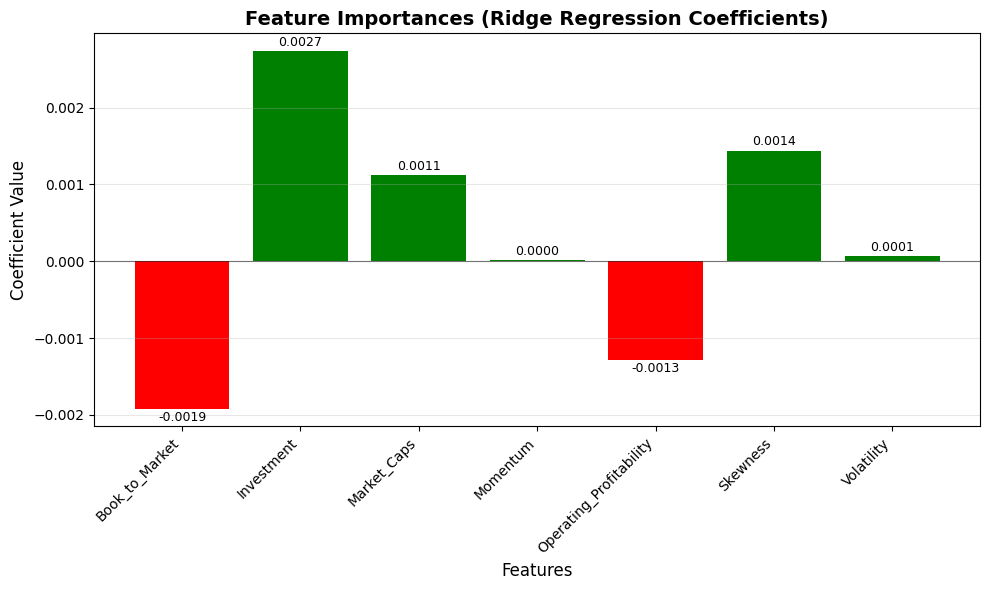

In [22]:
import matplotlib.pyplot as plt

# Get feature names and coefficients
feature_names = rank.columns.tolist()  # Features used in the model
coefficients = umve.ridge.coef_

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(
    range(len(feature_names)),
    coefficients,
    color=["green" if coef > 0 else "red" for coef in coefficients],
)

# Customize the chart
plt.title(
    "Feature Importances (Ridge Regression Coefficients)",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Coefficient Value", fontsize=12)
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)

# Add value labels on bars
for i, (bar, coef) in enumerate(zip(bars, coefficients)):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + np.sign(height) * max(abs(coefficients)) * 0.01,
        f"{coef:.4f}",
        ha="center",
        va="bottom" if height > 0 else "top",
        fontsize=9,
    )

# Add horizontal line at zero
plt.axhline(y=0, color="black", linestyle="-", alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.show()